## Task 2

For this homework, train few models on a selected dataset from https://github.com/ahxt/fair_fairness_benchmark/:

Prepare a knitr/jupiter notebook with the following points.
Submit your results on GitHub to the directory `Homeworks/HW1`.

1. Train a model for the selected dataset. 
2. For the selected protected attribute (age, gender, race) calculate the following fairness coefficients: Statistical parity, Equal opportunity, Predictive parity.
3. Train another model (different hyperparameters, feature transformations etc., different family of models) and see how the coefficients Statistical parity, Equal opportunity, Predictive parity behave for it. Are they different/similar?
4. Apply the selected bias mitigation technique (like data balancing) on the first model. Check how Statistical parity, Equal opportunity, Predictive parity coefficients behave after this mittigation.
5. Compare the quality (performance) of the three models with their fairness coefficients. Is there any correlation/trade off? 
6. ! COMMENT on the results obtained in (2)-(5)

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('german_credit_risk.csv', index_col=0)
df = pd.get_dummies(df, drop_first=True)
df['Young'] = df['Age'] < 30
df['Credit given'] = df['Class'] == 1
df.drop(columns=['Class', "Age"], inplace=True)
i_protected_attribute = np.arange(0, df.shape[1])[df.columns == "Young"].item()
df.head()

,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Young,Credit given
0,2,1169,6,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
1,2,5951,48,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,True,False
2,1,2096,12,True,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True
3,2,7882,42,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True
4,2,4870,24,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [3]:
X = df.values[:, :-1].astype(int)
Y = df.values[:, -1].astype(int)
sample_weight = np.where(Y, Y.shape[0] / Y.sum(), Y.shape[0] / (Y.shape[0] - Y.sum()))

### Model #1

In [4]:
from sklearn.ensemble import RandomForestClassifier

model_1 = RandomForestClassifier(n_estimators=20, min_samples_leaf=30, random_state=42)
model_1.fit(X, Y, sample_weight=sample_weight)
model_1.score(X, Y, sample_weight=sample_weight)

0.6669047619047621

### Model #2

In [5]:
from sklearn.linear_model import LogisticRegression

model_2 = LogisticRegression(random_state=42)
model_2.fit(X, Y, sample_weight=sample_weight)
model_2.score(X, Y, sample_weight=sample_weight)

/Users/pzal/Projects/mim-eml/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6116666666666668

### Model #3: model #2 + bias mitigation

In [6]:
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression(random_state=42)
model_3.fit(X, Y, sample_weight=sample_weight)

original_decision_function = model_3.decision_function


def my_decision_function(X):
    protected_mask = X[:, i_protected_attribute] == 1
    boost = 1.5
    original_decision = original_decision_function(X)
    original_decision[protected_mask] += boost
    return original_decision


model_3.decision_function = my_decision_function
model_3.score(X, Y, sample_weight=sample_weight)

/Users/pzal/Projects/mim-eml/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5490476190476191

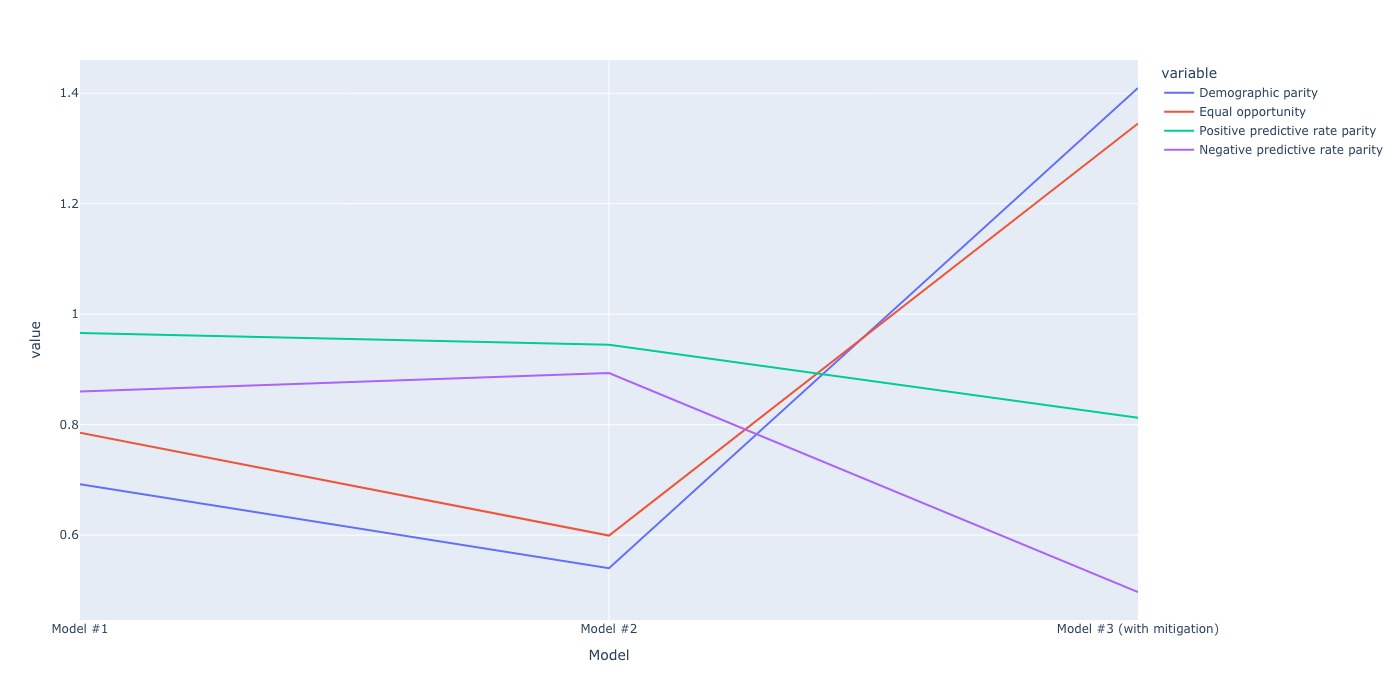

In [7]:
import plotly.express as px
import plotly.express as px
import plotly.io as pio
from IPython.display import Image


def low_memory_print(fig):
    # Interactive plots from plotly are very nice, but for
    # the final notebook version I'm printing a static image
    # instead, to reduce the size of the notebook.
    img_bytes = pio.to_image(fig, format="jpg", width=1400, height=700)
    display(Image(img_bytes))


def calculate_coefficients(model, X, Y):
    # Protected group

    protected_mask = X[:, i_protected_attribute] == 1
    _X = X[protected_mask]
    _Y = Y[protected_mask]

    Y_pred = model.predict(_X)

    protected_demographic_parity = Y_pred.mean()
    protected_equal_opportunity = Y_pred[_Y == 1].mean()
    protected_positive_predictive_rate_parity = _Y[Y_pred == 1].mean()
    protected_negative_predictive_rate_parity = _Y[Y_pred == 0].mean()

    # Unprotected group

    _X = X[~protected_mask]
    _Y = Y[~protected_mask]

    Y_pred = model.predict(_X)

    unprotected_demographic_parity = Y_pred.mean()
    unprotected_equal_opportunity = Y_pred[_Y == 1].mean()
    unprotected_positive_predictive_rate_parity = _Y[Y_pred == 1].mean()
    unprotected_negative_predictive_rate_parity = _Y[Y_pred == 0].mean()

    return (
        protected_demographic_parity / unprotected_demographic_parity,
        protected_equal_opportunity / unprotected_equal_opportunity,
        protected_positive_predictive_rate_parity
        / unprotected_positive_predictive_rate_parity,
        protected_negative_predictive_rate_parity
        / unprotected_negative_predictive_rate_parity,
    )


records = []

for model_name, model in (
    ("Model #1", model_1),
    ("Model #2", model_2),
    ("Model #3 (with mitigation)", model_3),
):
    (
        demographic_parity,
        equal_opportunity,
        positive_predictive_rate_parity,
        negative_predictive_rate_parity,
    ) = calculate_coefficients(model, X, Y)
    records.append(
        {
            "Model": model_name,
            "Demographic parity": demographic_parity,
            "Equal opportunity": equal_opportunity,
            "Positive predictive rate parity": positive_predictive_rate_parity,
            "Negative predictive rate parity": negative_predictive_rate_parity,
        }
    )

df = pd.DataFrame.from_records(records)
low_memory_print(
    px.line(
        df,
        x="Model",
        y=[
            "Demographic parity",
            "Equal opportunity",
            "Positive predictive rate parity",
            "Negative predictive rate parity",
        ],
    )
)

### Comments

I chose the "german credit risk" dataset, and used age as the protected attribute, with people under the age of 30 as the disadvantaged ones. In all models I introduce class weights, to balance the fact that there are much more samples where credit risk is considered low.

Model #1 is a random forest and achieves (balanced) accuracy of ~0.67.

Model #2 is a logistic regression and achieves (balanced) accuracy of ~0.61.

The fairness coefficients are different between these two models.

Model #3 is a logitic regression with everything like in model #2, except that it has mitigation applied, which boosts the scores from the model for the disadvantaged group. It achieves (balanced) accuracy of ~0.55, but it dramatically increases demographic parity and equal opportunity coefficient, but the trade-off is that the predictive parity coefficient drops.